In [133]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az
import pytensor.tensor as pt


Load Data

In [134]:
df_hourly_max = pd.read_pickle('prcp_hourly_max.pkl')
df_X = pd.read_pickle('stations_xy.pkl')

## MLE approach

In [135]:
params = {}

for station in df_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

df_GEV = pd.DataFrame(params).T
df_GEV

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.743041,0.218308,0.082367,1.282793,1.964037,0.091115,0.318363
BDL,0.866210,0.326382,0.082323,1.673127,2.691466,0.140195,0.549130
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
PHL,1.087505,0.381774,-0.018358,1.929132,2.771611,0.123407,0.335926
ILG,1.023899,0.317822,0.159448,1.884261,3.181259,0.164271,0.735896


In [208]:
df_annual_max = df_hourly_max.groupby(lambda x:x.year).max()

In [137]:
station = 'JFK'

ts_hourly_max = df_hourly_max[station]
ts_annual_max = df_annual_max[station]

GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [138]:
GEV_hourly.return_level(100)

3.085250101547203

In [140]:
# data =ts_annual_max.values

# # return_periods = GEV_hourly._return_periods(n=50)
# return_periods = np.logspace(0.01,2, num=100)
# p = 1/return_periods

# with pm.Model() as model:
#     # Priors
#     μ = pm.Normal("μ", mu=1.0, sigma=0.5)
#     σ = pm.HalfNormal("σ", sigma=0.5)
#     ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

#     # Estimation
#     gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
#     # Return level
#     z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))
#     # z_p = pm.Deterministic("z_p", gev_returnlevel(return_periods, μ, σ, ξ))
#     gev_returnlevel

In [141]:
GEV_hourly.return_level(100), GEV_hourly.return_level_se(100)

(3.085250101547203, array(0.60981525))

In [142]:
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [143]:


#upgrade to halversine distance
#https://en.wikipedia.org/wiki/Haversine_formula

class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * pt.stack(
            [
                pt.cos(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = pt.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return pt.sqrt(pt.sum(((X - Xs) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + np.sqrt(3.0) * r) * pt.exp(-np.sqrt(3.0) * r)

In [144]:
f = 


SyntaxError: invalid syntax (2391194814.py, line 1)

In [145]:
sample_cols = df_annual_max.columns
# sample_cols = ['JFK','LGA','EWR']

df_X_y = df_annual_max[sample_cols].stack().to_frame('PRCP').join(df_X)
X_ = df_X_y[['X','Y']].to_numpy()
y_ = df_X_y['PRCP'].to_numpy()
X_.shape, y_.shape

df_X_y_ = df_X_y.reset_index()
station_idx, stations = df_X_y_['station'].factorize(sort=True)
X = df_X.loc[stations][['X','Y']].to_numpy()

In [146]:
stations

Index(['BDL', 'BOS', 'EWR', 'ILG', 'JFK', 'LGA', 'PHL'], dtype='object')

In [148]:
coords = {
    "cov_params": ["mu","sigma"],
    "location" : ["x","y"],
    "station" : stations,
    "obs" : df_X_y_.index,
    
}

with pm.Model(coords=coords) as gp_model:
    pt_station_idx = pm.ConstantData("station_idx", station_idx, dims="obs")
    pt_X = pm.ConstantData("station_loc", X, dims=("station","location"))

    ℓ = pm.InverseGamma("ℓ", mu = 150.0, sigma = 50.0)
    η = pm.Gamma("η", mu=0.15, sigma=0.15, dims = "cov_params")

    cov_μ = η[0]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    gp_μ = pm.gp.Latent(cov_func=cov_μ)
    μ_group = pm.Normal("μ_group", mu=1.0, sigma=2.0)
    μ = pm.Deterministic("μ", μ_group + gp_μ.prior("μ_gp", X=pt_X, dims="station"))

    cov_σ_log = η[1]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    gp_σ_log = pm.gp.Latent(cov_func=cov_σ_log)
    σ_log = gp_σ_log.prior("σ_log", X=pt_X, dims="station")
    σ_log_group = pm.Normal("σ_log_group", mu=-1.0, sigma=5.0)
    σ = pm.Deterministic("σ", pm.math.exp(σ_log_group + σ_log))

    # cov_ξ = η[2]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    # gp_ξ = pm.gp.Latent(cov_func=cov_ξ)
    # ξ_group = pm.Normal("ξ_group", mu=0, sigma=0.15)
    # ξ = pm.Deterministic("ξ", pm.math.tanh(ξ_group + gp_ξ.prior("ξ_gp", X=pt_X, dims="station")))

    ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

    gev = pmx.GenExtreme("gev", 
                         mu=μ[pt_station_idx],
                         sigma=σ[pt_station_idx],
                         xi=ξ,
                         observed=y_,
                         dims="obs")

    gp_trace = pm.sample(1000, 
        tune = 1000, 
        # chains = 2, 
        # cores = 2, 
        target_accept = 0.98,
        # nuts_sampler = "numpyro"
        )

# pm.model_to_graphviz(gp_model)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, μ_group, μ_gp_rotated_, σ_log_rotated_, σ_log_group, ξ]
INFO:pymc.sampling.mcmc:NUTS: [ℓ, η, μ_group, μ_gp_rotated_, σ_log_rotated_, σ_log_group, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 361 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 361 seconds.


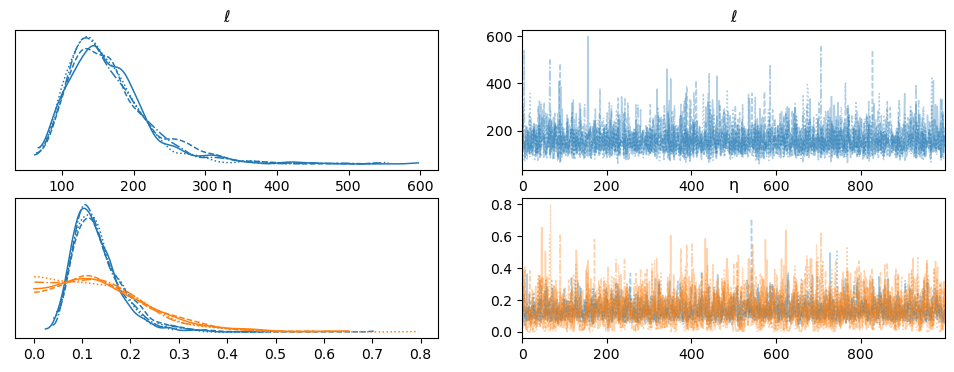

In [149]:
az.plot_trace(gp_trace, var_names=["ℓ", "η"]);

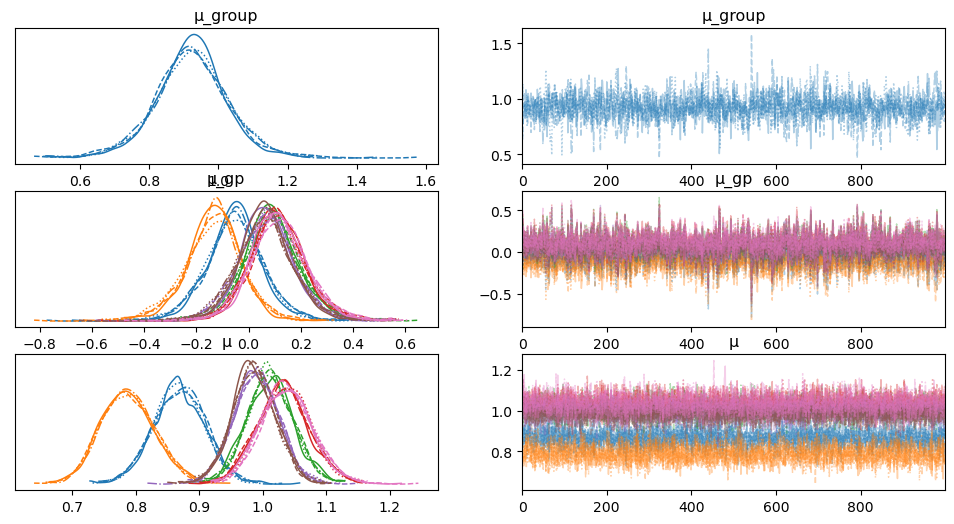

In [150]:
az.plot_trace(gp_trace, var_names=["μ_group","μ_gp","μ"]);

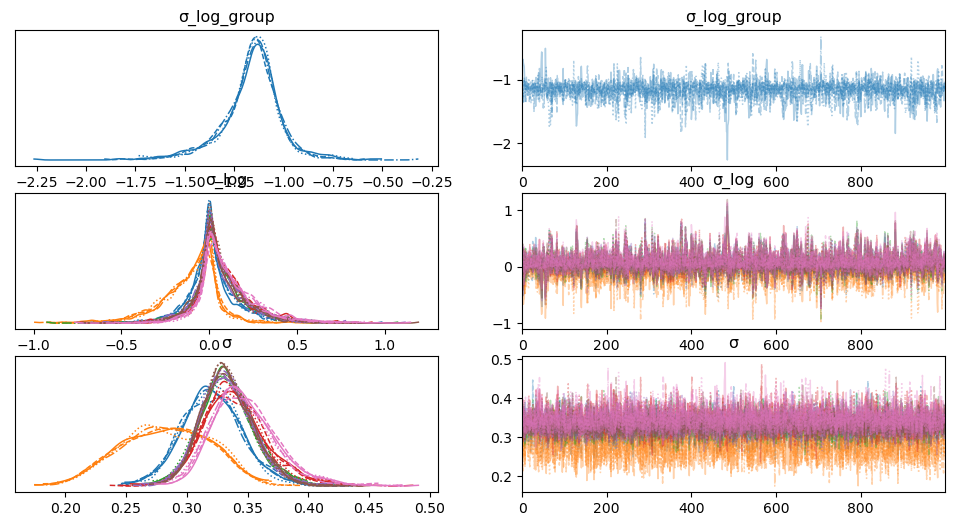

In [151]:
az.plot_trace(gp_trace, var_names=["σ_log_group","σ_log","σ"]);

In [152]:
az.summary(gp_trace,var_names=["ℓ", "η"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ,164.077,57.210,73.960,274.018,0.972,0.748,4395.0,2553.0,1.0
η[mu],0.133,0.053,0.048,0.232,0.001,0.001,1704.0,2530.0,1.0
η[sigma],0.143,0.099,0.000,0.326,0.003,0.002,1091.0,1117.0,1.0


In [153]:
az.summary(gp_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95).sort_values('r_hat')

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.868,0.041,0.790,0.949,0.001,0.000,4370.0,3991.0,1.0
μ[1],0.788,0.042,0.711,0.874,0.001,0.001,3079.0,2518.0,1.0
μ[2],1.012,0.037,0.942,1.089,0.001,0.000,4667.0,3678.0,1.0
μ[3],1.033,0.041,0.951,1.110,0.001,0.000,5066.0,3387.0,1.0
μ[4],0.990,0.035,0.918,1.055,0.000,0.000,5540.0,3793.0,1.0
μ[5],0.986,0.034,0.918,1.052,0.000,0.000,5437.0,3982.0,1.0
μ[6],1.038,0.041,0.960,1.119,0.001,0.000,4777.0,4018.0,1.0
σ[0],0.321,0.025,0.273,0.373,0.000,0.000,4920.0,3988.0,1.0
σ[1],0.283,0.036,0.217,0.348,0.001,0.001,1591.0,2288.0,1.0
σ[2],0.333,0.023,0.290,0.382,0.000,0.000,4630.0,3667.0,1.0


In [154]:
X_sample = df_X.loc[sample_cols][['X','Y']].to_numpy()
# X_sample = df_X[['X','Y']].to_numpy()

pred_vars = ["mu_pred1", "sigma_log_pred1", "xi_pred1","z_p_101","z_p_1001"]
pred_vars = ["mu_pred3", "mu_pred_gp3", "sigma_log_pred3","sigma_pred3", "ξ"]
jitter = 1e-6

with gp_model:
    mu_pred = pm.Deterministic(pred_vars[0], μ_group + gp_μ.conditional(pred_vars[1], Xnew=X_sample, jitter=jitter))
    sigma_log_pred = gp_σ_log.conditional(pred_vars[2], Xnew=X_sample, jitter=jitter)
    sigma_pred = pm.Deterministic(pred_vars[3], pm.math.exp(σ_log_group+sigma_log_pred))

    posterior_pred = pm.sample_posterior_predictive(gp_trace, var_names=pred_vars)

Sampling: [mu_pred_gp3, sigma_log_pred3, ξ]
INFO:pymc.sampling.forward:Sampling: [mu_pred_gp3, sigma_log_pred3, ξ]


In [155]:
pred_xi = az.extract(posterior_pred.posterior_predictive, var_names="ξ")
pred_mu = az.extract(posterior_pred.posterior_predictive, var_names="mu_pred3")
pred_sigma = az.extract(posterior_pred.posterior_predictive, var_names="sigma_pred3")

In [156]:
gev_returnlevel(10.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)
# gev_returnlevel(100.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)

array([1.43860106, 1.60703133, 1.75622092, 1.7539409 , 1.77811847,
       1.83720879, 1.81371486])

In [157]:
gev_returnlevel(100.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)

array([2.20911117, 2.48129791, 2.66354102, 2.66315201, 2.68533419,
       2.78382537, 2.73813444])

In [ ]:
df_GEV

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.743041,0.218308,0.082367,1.282793,1.964037,0.091115,0.318363
BDL,0.866210,0.326382,0.082323,1.673127,2.691466,0.140195,0.549130
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
PHL,1.087505,0.381774,-0.018358,1.929132,2.771611,0.123407,0.335926
ILG,1.023899,0.317822,0.159448,1.884261,3.181259,0.164271,0.735896


In [101]:
return_periods = np.logspace(0.01,2, num=100)
p = 1/return_periods

In [119]:
ts_y = df_annual_max[['JFK','LGA','EWR']]
# ts_y = df_annual_max[['ILG']]

In [161]:


for station in df_annual_max.columns:
  coords = {
    "station" : ts_y.columns,
    "obs" : ts_y.index,
    "rp" : return_periods
    
}



  print(station)
  ts_y = df_annual_max[[station]]

  with pm.Model(coords = coords) as model:

      p = pm.ConstantData("p", 1/return_periods, dims="rp")
      # Priors
      μ = pm.Normal("μ", mu=1.0, sigma=0.5, dims='station')
      σ = pm.HalfNormal("σ", sigma=0.5, dims='station')
      ξ = pm.Normal("ξ", mu=0, sigma=0.15, dims='station')
      ξ_ = pm.Deterministic("ξ_", pm.math.tanh(ξ), dims='station')

      gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ_, observed=ts_y.to_numpy(), dims=('obs','station'))

      # z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)), dims=('station','rp'))
      trace = pm.sample(1000,
                        tune = 1000, 
                        target_accept = 0.98,
                      #   initvals={"μ": [1.0]*7, "σ": [0.3]*7, "ξ": [0.01]*7},
                        )

# pm.model_to_graphviz(model)

BOS


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


BDL


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


JFK


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


LGA


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


EWR


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


PHL


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


ILG


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [204]:
ts_y = df_annual_max

coords = {
    "station" : ts_y.columns,
    "obs" : ts_y.index,
    "rp" : return_periods 
}

with pm.Model(coords = coords) as unpooled_model:

    p = pm.ConstantData("p", 1/return_periods, dims="rp")
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=0.5, dims='station')
    σ = pm.HalfNormal("σ", sigma=0.5, dims='station')
    ξ = pm.TruncatedNormal('ξ', mu=0.0, sigma=0.15, lower=-0.99, upper=0.99,dims='station')
    # ξ = pm.Normal("ξ", mu=0, sigma=0.15, dims='station')
    # ξ_ = pm.Deterministic("ξ_", pm.math.tanh(ξ), dims='station')

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=ts_y.to_numpy(), dims=('obs','station'))

    # rl_10 = pm.Deterministic("rl_10", μ - σ / ξ * (1 - (-np.log(1 - 1/10)) ** (-ξ)), dims='station')
    # rl_50 = pm.Deterministic("rl_50", μ - σ / ξ * (1 - (-np.log(1 - 1/50)) ** (-ξ)), dims='station')
    rl_100 = pm.Deterministic("rl_100", μ - σ / ξ * (1 - (-np.log(1 - 1/100)) ** (-ξ)), dims='station')
    # rl_200 = pm.Deterministic("rl_200", μ - σ / ξ * (1 - (-np.log(1 - 1/200)) ** (-ξ)), dims='station')
    # rl = pm.Deterministic("rl", μ[:,None] - σ[:,None] / ξ[:,None] * (1 - (-np.log(1 - p[None:,])) ** (-ξ[:,None])), dims=('station','rp'))


    trace = pm.sample(2000, target_accept = 0.98 )
    

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]
INFO:pymc.sampling.mcmc:NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


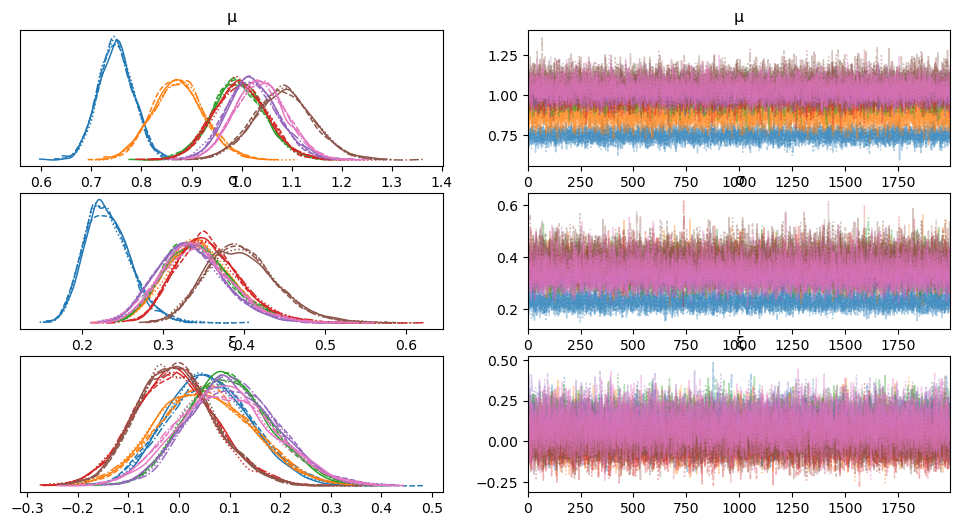

In [205]:
az.plot_trace(trace, var_names=["μ", "σ", "ξ"]);

In [206]:
az.summary(trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[BOS],0.749,0.035,0.680,0.816,0.000,0.000,6267.0,5602.0,1.0
μ[BDL],0.874,0.052,0.776,0.978,0.001,0.000,5597.0,5759.0,1.0
μ[JFK],0.994,0.053,0.889,1.098,0.001,0.000,5998.0,5169.0,1.0
μ[LGA],0.998,0.053,0.895,1.100,0.001,0.000,7458.0,5896.0,1.0
μ[EWR],1.022,0.051,0.927,1.129,0.001,0.000,5847.0,5179.0,1.0
μ[PHL],1.084,0.059,0.963,1.195,0.001,0.001,6392.0,5267.0,1.0
μ[ILG],1.038,0.051,0.936,1.135,0.001,0.000,6277.0,6088.0,1.0
σ[BOS],0.232,0.029,0.179,0.289,0.000,0.000,6359.0,6002.0,1.0
σ[BDL],0.346,0.042,0.265,0.429,0.001,0.000,6151.0,5642.0,1.0
σ[JFK],0.344,0.042,0.266,0.430,0.001,0.000,6177.0,6114.0,1.0


In [207]:
az.summary(trace,var_names=["rl"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rl[BOS, 1.023292992280754]",0.452,0.042,0.370,0.528,0.000,0.000,12219.0,5275.0,1.0
"rl[BOS, 1.0717685528461807]",0.525,0.035,0.454,0.590,0.000,0.000,12046.0,5280.0,1.0
"rl[BOS, 1.1225405035851537]",0.569,0.033,0.505,0.632,0.000,0.000,10239.0,5373.0,1.0
"rl[BOS, 1.1757176293733433]",0.603,0.032,0.541,0.665,0.000,0.000,8818.0,5506.0,1.0
"rl[BOS, 1.2314138684568319]",0.632,0.031,0.571,0.694,0.000,0.000,7835.0,5629.0,1.0
...,...,...,...,...,...,...,...,...,...
"rl[ILG, 83.09903099947317]",2.944,0.471,2.216,3.896,0.006,0.004,10216.0,4986.0,1.0
"rl[ILG, 87.0356084416433]",2.969,0.482,2.224,3.942,0.006,0.004,10194.0,4986.0,1.0
"rl[ILG, 91.15866991102556]",2.995,0.494,2.239,3.997,0.006,0.004,10176.0,4986.0,1.0
"rl[ILG, 95.47704955172505]",3.021,0.505,2.250,4.048,0.006,0.005,10160.0,4969.0,1.0


In [180]:
az.summary(trace,var_names=["rl_100"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rl_100[BOS],2.009,0.296,1.551,2.592,0.004,0.003,9976.0,4762.0,1.0
rl_100[BDL],2.716,0.444,2.025,3.559,0.005,0.004,11800.0,5309.0,1.0
rl_100[JFK],3.048,0.492,2.301,4.055,0.006,0.004,9882.0,5253.0,1.0
rl_100[LGA],2.639,0.364,2.083,3.331,0.005,0.004,9924.0,5234.0,1.0
rl_100[EWR],3.072,0.506,2.322,4.123,0.006,0.004,10226.0,5061.0,1.0
rl_100[PHL],2.928,0.382,2.326,3.687,0.005,0.004,8920.0,4813.0,1.0
rl_100[ILG],3.043,0.500,2.245,4.047,0.006,0.004,10496.0,5437.0,1.0


In [181]:
az.summary(trace,var_names=["rl_200"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rl_200[BOS],2.245,0.404,1.641,3.021,0.005,0.004,9921.0,4849.0,1.0
rl_200[BDL],3.056,0.611,2.146,4.217,0.007,0.005,11105.0,5236.0,1.0
rl_200[JFK],3.472,0.681,2.454,4.842,0.008,0.006,9790.0,5081.0,1.0
rl_200[LGA],2.896,0.481,2.185,3.786,0.006,0.005,9750.0,5183.0,1.0
rl_200[EWR],3.506,0.708,2.432,4.898,0.009,0.007,9984.0,5146.0,1.0
rl_200[PHL],3.218,0.499,2.479,4.224,0.006,0.005,9171.0,4849.0,1.0
rl_200[ILG],3.453,0.700,2.397,4.844,0.008,0.006,10181.0,5770.0,1.0


In [182]:
def gev_returnlevel(rp, μ, σ, ξ):
    p = 1.0 / rp
    return μ - (σ / ξ) * (1 - np.power(-np.log(1.0 - p), -ξ))

In [197]:
rp_ar = np.array([10.0, 20.0, 50.0]).reshape(1,-1)

mu_ar = np.array([0.9,1.0]).reshape(-1,1)
sigma_ar = np.array([0.3,0.4]).reshape(-1,1)
xi_ar = np.array([0.01, 0.1]).reshape(-1,1)

In [198]:
gev_returnlevel(rp_ar, mu_ar, sigma_ar, xi_ar)

array([[1.58276373, 1.80442366, 2.09371924],
       [2.00947487, 2.38336631, 2.90906863]])